In [7]:
import numpy as np
import pandas as pd
from PIL import Image
import scipy
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from tensorflow.keras import regularizers
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K
from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from skimage import morphology
from PIL import Image, ImageOps

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


In [8]:
import torch
import torchvision
import fastai
import os
import pandas as pd
import shutil
import random
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# from sklearn.metrics import precision_score, recall_score, roc_auc_score
# from torchvision.models import ResNet50_Weights
import torchvision.transforms as transforms
from PIL import Image
import pydicom
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score


In [10]:
csv_path = '/kaggle/input/iaaa-mri-challenge/train.csv'
df = pd.read_csv(csv_path)
separated_data_folder = '/kaggle/working/separated_data'
data_folder = '/kaggle/input/iaaa-mri-challenge/data'

normal_folder = os.path.join(separated_data_folder, 'normal')
abnormal_folder = os.path.join(separated_data_folder, 'abnormal')

# Iterate through the CSV file and move folders
for index, row in df.iterrows():
    series_uid = row['SeriesInstanceUID']
    prediction = row['prediction']
    
    # Determine the source and destination paths
    src_folder = os.path.join(data_folder, series_uid)
    if prediction == 0:
        dst_folder = os.path.join(normal_folder, series_uid)
    else:
        dst_folder = os.path.join(abnormal_folder, series_uid)
    
    # Move the folder
    if os.path.exists(src_folder):
        shutil.copytree(src_folder, dst_folder)
    else:
        print(f"Folder {src_folder} does not exist")

print("Folders separated successfully!")

Folders separated successfully!


In [11]:
# Paths to the normal and abnormal folders
base_folder = '/kaggle/working/splited_dataset'

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create directories for train, val, and test sets
train_folder = os.path.join(base_folder, 'train')
val_folder = os.path.join(base_folder, 'val')
test_folder = os.path.join(base_folder, 'test')

# Function to split and move folders
def split_and_move_folders(src_folder, dst_base_folder):
    folders = [f for f in os.listdir(src_folder) if os.path.isdir(os.path.join(src_folder, f))]
    random.shuffle(folders)
    
    train_count = int(len(folders) * train_ratio)
    val_count = int(len(folders) * val_ratio)
    test_count = len(folders) - train_count - val_count
    
    splits = {
        'train': folders[:train_count],
        'val': folders[train_count:train_count + val_count],
        'test': folders[train_count + val_count:]
    }
    
    for split, split_folders in splits.items():
        for folder in split_folders:
            src_path = os.path.join(src_folder, folder)
            dst_path = os.path.join(dst_base_folder, split, os.path.basename(src_folder), folder)
            shutil.move(src_path, dst_path)

# Split and move normal and abnormal folders
split_and_move_folders(normal_folder, base_folder)
split_and_move_folders(abnormal_folder, base_folder)

print("Data split into train, val, and test sets successfully!")

Data split into train, val, and test sets successfully!


In [12]:
def process_and_save_dicom(src_folder, dst_folder):
    for root, _, files in os.walk(src_folder):
        for file in files:
            if file.endswith(".dcm"):
                dicom_path = os.path.join(root, file)
                dicom_data = pydicom.dcmread(dicom_path)
            if 'FLAIR'  in dicom_data.ProtocolName:

                # Extract metadata
                slice_orientation = dicom_data[(0x2001, 0x100b)].value
                if (slice_orientation != 'SAGITTAL') and (slice_orientation != 'CORONAL'):
                    pixel_array = dicom_data.pixel_array
                    protocol_name = dicom_data.ProtocolName.replace(" ", "_")  # Remove spaces in description
                    instance_number = dicom_data.InstanceNumber

                    # Extract Image Orientation (Patient) tag to determine left-right orientation
                    image_orientation = dicom_data[0x0020, 0x0037].value

                    # Check if the first element of image_orientation is negative
                    # This would indicate a left-to-right orientation, requiring a flip
                    if image_orientation[0] < 0:
                        # Flip the image horizontally to make it right-to-left
                        pixel_array = np.fliplr(pixel_array)

                    # Get the original folder name (parent of current root)
                    original_folder_name = os.path.basename(root)

                    # Create a new folder for the subject using original folder name + PatientID
                    subject_folder_name = f"{original_folder_name}"
                    subject_folder = os.path.join(dst_folder, subject_folder_name)
                    os.makedirs(subject_folder, exist_ok=True)

                    # Construct the save path with instance number in the filename
                    save_path = os.path.join(subject_folder, f"{os.path.splitext(file)[0]}_{protocol_name}_Instance{instance_number}.npy")

                    # Save the numpy array
                    np.save(save_path, pixel_array)
    


output_folder = '/kaggle/working/final_data'
# Process and save DICOM files in train, val, and test sets
for subset in ['train', 'val', 'test']:
    for category in ['normal', 'abnormal']:
        src_folder = os.path.join(base_folder, subset, category)
        dst_folder = os.path.join(output_folder, subset, category)
        process_and_save_dicom(src_folder, dst_folder)

print("DICOM files processed and saved as NumPy arrays with SeriesDescription in filenames.")


done
DICOM files processed and saved as NumPy arrays with SeriesDescription in filenames.


In [13]:
def extract_instance_number(filename):
    base_name = os.path.splitext(os.path.basename(filename))[0]
    instance_str = base_name.split('_')[-1]  # Get the last part after splitting by '_'
    instance_number = ''.join(filter(str.isdigit, instance_str))    
    return int(instance_number)

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    if "normal" in dir_path.lower():
           label = 0 
    if "abnormal" in dir_path.lower():
           label = 1 
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        x_temp = []
        if not path.startswith('.'):
           
            # Get all .npy files in the subject's folder
            npy_files = [os.path.join(dir_path + path, f) for f in os.listdir(dir_path + path) if f.endswith(".npy")]
            if not npy_files:
                print("No .npy files found for the selected subject.")
                return
            # Sort files based on extracted instance numbers
            npy_files = sorted(npy_files, key=extract_instance_number)
            for i, file_path in enumerate(npy_files):
                # Load the image data from the .npy file
                image_data = np.load(file_path)
                # Resize the image to a consistent shape (img_size)
                image_data = cv2.resize(image_data, img_size)
                x_temp.append(image_data)

            x_temp = np.array(x_temp)
            if len(x_temp) < 16:
                padding = np.zeros((16 - len(x_temp),) + x_temp.shape[1:])
                x_temp = np.concatenate((x_temp, padding), axis=0)
            x_temp = x_temp[:16]
            X.append(x_temp)
            y.append(label)
            i += 1

    return X, y


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [14]:
TRAIN_DIR_noraml = 'final_data/train/normal/'
TRAIN_DIR_abnoraml = 'final_data/train/abnormal/'
VAL_DIR_noraml = 'final_data/val/normal/'
VAL_DIR_abnoraml = 'final_data/val/abnormal/'
TEST_DIR_noraml = 'final_data/test/normal/'
TEST_DIR_abnoraml = 'final_data/test/abnormal/'
IMG_SIZE = (224,224)

In [15]:
X_train_n, y_train_n = load_data(TRAIN_DIR_noraml, IMG_SIZE)
X_val_n, y_val_n = load_data(VAL_DIR_noraml, IMG_SIZE)
X_test_n, y_test_n = load_data(TEST_DIR_noraml, IMG_SIZE)

X_train_a, y_train_a = load_data(TRAIN_DIR_abnoraml, IMG_SIZE)
X_val_a, y_val_a = load_data(VAL_DIR_abnoraml, IMG_SIZE)
X_test_a, y_test_a = load_data(TEST_DIR_abnoraml, IMG_SIZE)

X_train = np.concatenate((X_train_n, X_train_a), axis=0)
y_train = np.concatenate((y_train_n, y_train_a), axis=0)
X_val = np.concatenate((X_val_n, X_val_a), axis=0)
y_val = np.concatenate((y_val_n, y_val_a), axis=0)
X_test = np.concatenate((X_test_n, X_test_a), axis=0)
y_test = np.concatenate((y_test_n, y_test_a), axis=0)

100%|██████████| 21/21 [00:00<00:00, 187.90it/s]


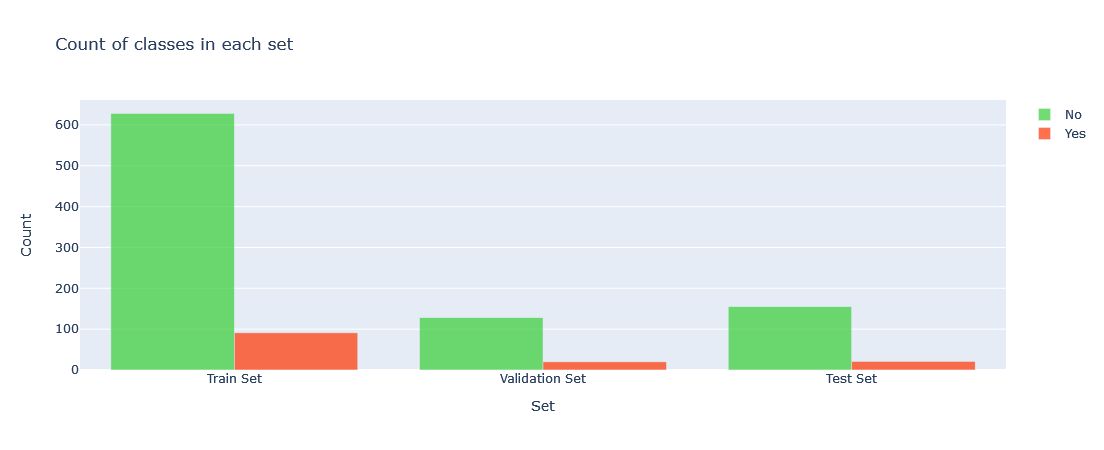

In [16]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [20]:
def crop_imgs(set_name, add_pixels_value=10, img_size=(224, 224), min_contour_area=500):
    """
    Finds the extreme points on the image and crops the rectangular region out of them
    for each slice in the 3D .npy data.
    """
    set_new = []
    
    # Iterate over the set_name which contains 3D volumes (multiple slices)
    for volume in set_name:
        cropped_slices = []
        selected_slices = volume[4:8]
        # Iterate over each 2D slice in the 3D volume
        for img in volume:
            # Ensure the image is in grayscale format
            if len(img.shape) == 3:  # (height, width, channels)
                image_2d = img[:, :, 0]  # Use the first channel for cropping
            else:
                image_2d = img
                
            binary_image = image_2d > np.percentile(image_2d, 60)

            # Remove small connected components (noise) - optional
            binary_image = morphology.remove_small_objects(binary_image, min_size=100)

            coords = np.column_stack(np.where(binary_image))
            if coords.size == 0:
                # If no valid cropping, resize the original image
                cropped_image = cv2.resize(
                    img,  # Fix here: use img instead of undefined cropped_image
                    dsize=img_size,
                    interpolation=cv2.INTER_CUBIC
                )
            else:
                # Crop the image using the bounding box of non-zero pixels
                min_row, min_col = coords.min(axis=0)
                max_row, max_col = coords.max(axis=0)
                cropped_image = img[min_row:max_row+1, min_col:max_col+1]

                # Resize cropped image as you originally had it
                cropped_image = cv2.resize(
                    cropped_image,  # Keep this as cropped_image as it was
                    dsize=img_size,
                    interpolation=cv2.INTER_CUBIC
                )

            # Ensure the resized image has a channel dimension
            if len(cropped_image.shape) == 2:
                cropped_image = np.expand_dims(cropped_image, axis=-1)
            
            cropped_slices.append(cropped_image)

        # Append the cropped volume (list of 2D slices)
        set_new.append(np.array(cropped_slices))

    return np.array(set_new)


In [21]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

In [23]:
def save_new_images(x_set, y_set, folder_name):
    normal_folder = os.path.join(folder_name, 'normal')
    abnormal_folder = os.path.join(folder_name, 'abnormal')
    
    os.makedirs(normal_folder, exist_ok=True)
    os.makedirs(abnormal_folder, exist_ok=True)
    
    for i, (volume, imclass) in enumerate(zip(x_set, y_set)):

        # Create a folder for each sample
        sample_folder = os.path.join(normal_folder if imclass == 0 else abnormal_folder, f'sample_{i}')
        os.makedirs(sample_folder, exist_ok=True)

        for slice_idx,j in enumerate(volume):


            img = j
            
            # Ensure img is of type uint8
            if img.dtype != np.uint8:
                img = img.astype(np.uint8)                
#             print("img.shape: ",img.shape)
            # Save the image
            save_path = os.path.join(sample_folder, f'slice_{slice_idx}.jpg')
            if not cv2.imwrite(save_path, img):
                raise IOError(f"Failed to write image to {save_path}")


In [26]:
def save_new_images(x_set, y_set, folder_name):
    normal_folder = os.path.join(folder_name, 'normal')
    abnormal_folder = os.path.join(folder_name, 'abnormal')
    
    os.makedirs(normal_folder, exist_ok=True)
    os.makedirs(abnormal_folder, exist_ok=True)
    
    for i, (volume, imclass) in enumerate(zip(x_set, y_set)):
        
        # Create a folder for each sample
        sample_folder = os.path.join(normal_folder if imclass == 0 else abnormal_folder, f'sample_{i}')
        os.makedirs(sample_folder, exist_ok=True)

        for slice_idx,j in enumerate(volume):
            img = j
            # Ensure img is of type uint8
            if img.dtype != np.uint8:
                img = img.astype(np.uint8)                
            # Save the image
            save_path = os.path.join(sample_folder, f'slice_{slice_idx}.jpg')
            if not cv2.imwrite(save_path, img):
                raise IOError(f"Failed to write image to {save_path}")


In [27]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for volume in set_name:
        # Discard all slices except slices 5, 6, 7, and 8
        selected_slices = volume[4:8]  # Indices 4 to 7 correspond to slices 5 to 8
        # Append the processed volume to the new set
        set_new.append(np.array(selected_slices))
    return np.array(set_new)

In [28]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [30]:
print(X_train_prep.shape)
print(X_train_prep[0].shape)

(719, 4, 224, 224, 1)
(4, 224, 224, 1)


In [31]:
save_new_images(X_train_prep, y_train, folder_name='train_crop/')
save_new_images(X_val_prep, y_val, folder_name='val_crop/')
save_new_images(X_test_prep, y_test, folder_name='test_crop/')

In [32]:

# ImageDataGenerator with your chosen augmentation settings
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    #rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    #horizontal_flip=True,
    vertical_flip=True
)

# Set paths
TRAIN_DIR = '/kaggle/working/train_crop/'
AUGMENTED_DIR = 'AUGMENTED_TRAIN_CROP/'
os.makedirs(AUGMENTED_DIR, exist_ok=True)

# Loop through each class (normal/abnormal)
for class_folder in os.listdir(TRAIN_DIR):
    #print(class_folder)
    if class_folder == "normal":
        #print("normal--")
        N = 2
    else:
        N = 5
        #print("abnormal--")
        
    class_path = os.path.join(TRAIN_DIR, class_folder)
    
    # Loop through each sample folder
    for sample_folder in os.listdir(class_path):

        sample_path = os.path.join(class_path, sample_folder)

        # Load the four slices from the sample folder
        slices = []
        for slice_file in sorted(os.listdir(sample_path)):
            slice_path = os.path.join(sample_path, slice_file)
            img = cv2.imread(slice_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            slices.append(img)
        
        # Generate and save N augmented samples
        for aug_idx in range(N):  # If you want N different augmentations
            augmented_sample_dir = os.path.join(AUGMENTED_DIR, class_folder, f'{sample_folder}_aug_{aug_idx}')
            os.makedirs(augmented_sample_dir, exist_ok=True)

            augmented_slices = []
            for j, img_slice in enumerate(slices):
                img_slice = img_slice.reshape((1,) + img_slice.shape + (1,))  # Reshape to (1, height, width, 1)
                aug_iter = demo_datagen.flow(img_slice, batch_size=1)
                
                augmented_img = next(aug_iter)[0]  # Get augmented image
                augmented_img = (augmented_img * 255).astype(np.uint8)  # Rescale back to original scale
                
                save_path = os.path.join(augmented_sample_dir, f'slice_{j}.jpg')
                cv2.imwrite(save_path, augmented_img)
                
                augmented_slices.append(augmented_img)
        #save the original
        original_sample_dir = os.path.join(AUGMENTED_DIR, class_folder, f'{sample_folder}_original')
        os.makedirs(original_sample_dir, exist_ok=True)        
        for j, img_slice in enumerate(slices):
           # img_slice = img_slice.reshape((1,) + img_slice.shape + (1,))  # Reshape to (1, height, width, 1)
            
            save_path = os.path.join(original_sample_dir, f'slice_{j}.jpg')
            cv2.imwrite(save_path, img_slice)

print("Augmentation complete!")


Augmentation complete!


In [34]:
def average_slices_and_save(src_folder, dst_folder, img_size=(224, 224)):
    """
    Averages the four .jpg slices of each sample and saves the resulting image.
    """
    for category in ['normal', 'abnormal']:
        category_src_folder = os.path.join(src_folder, category)
        category_dst_folder = os.path.join(dst_folder, category)
        
        # Create the destination folder if it doesn't exist
        os.makedirs(category_dst_folder, exist_ok=True)
        
        for sample_folder in tqdm(os.listdir(category_src_folder)):
            sample_path = os.path.join(category_src_folder, sample_folder)
            if os.path.isdir(sample_path):
                slices = []
                
                for slice_file in sorted(os.listdir(sample_path)):
                    if slice_file.endswith(".jpg"):
                        slice_path = os.path.join(sample_path, slice_file)
                        slice_img = cv2.imread(slice_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
                        smoothed_img = cv2.blur(slice_img, (3, 3))
                        slices.append(smoothed_img)
                
                # Ensure there are four slices
                if len(slices) == 4:
                    # Average the slices
                    #print("here")
                    averaged_slice = np.mean(slices, axis=0)
                    
                    # Save the averaged slice as an image
                    save_path = os.path.join(category_dst_folder, f'{sample_folder}.jpg')
                    cv2.imwrite(save_path, averaged_slice)
                    
    print("Slices averaged and saved successfully!")

# Paths to the normal and abnormal folders
src_folder = '/kaggle/working/AUGMENTED_TRAIN_CROP'
dst_folder = '/kaggle/working/TRAIN_AVG'

# Call the function to average slices and save them
average_slices_and_save(src_folder, dst_folder)


100%|██████████| 546/546 [00:01<00:00, 440.61it/s]

Slices averaged and saved successfully!


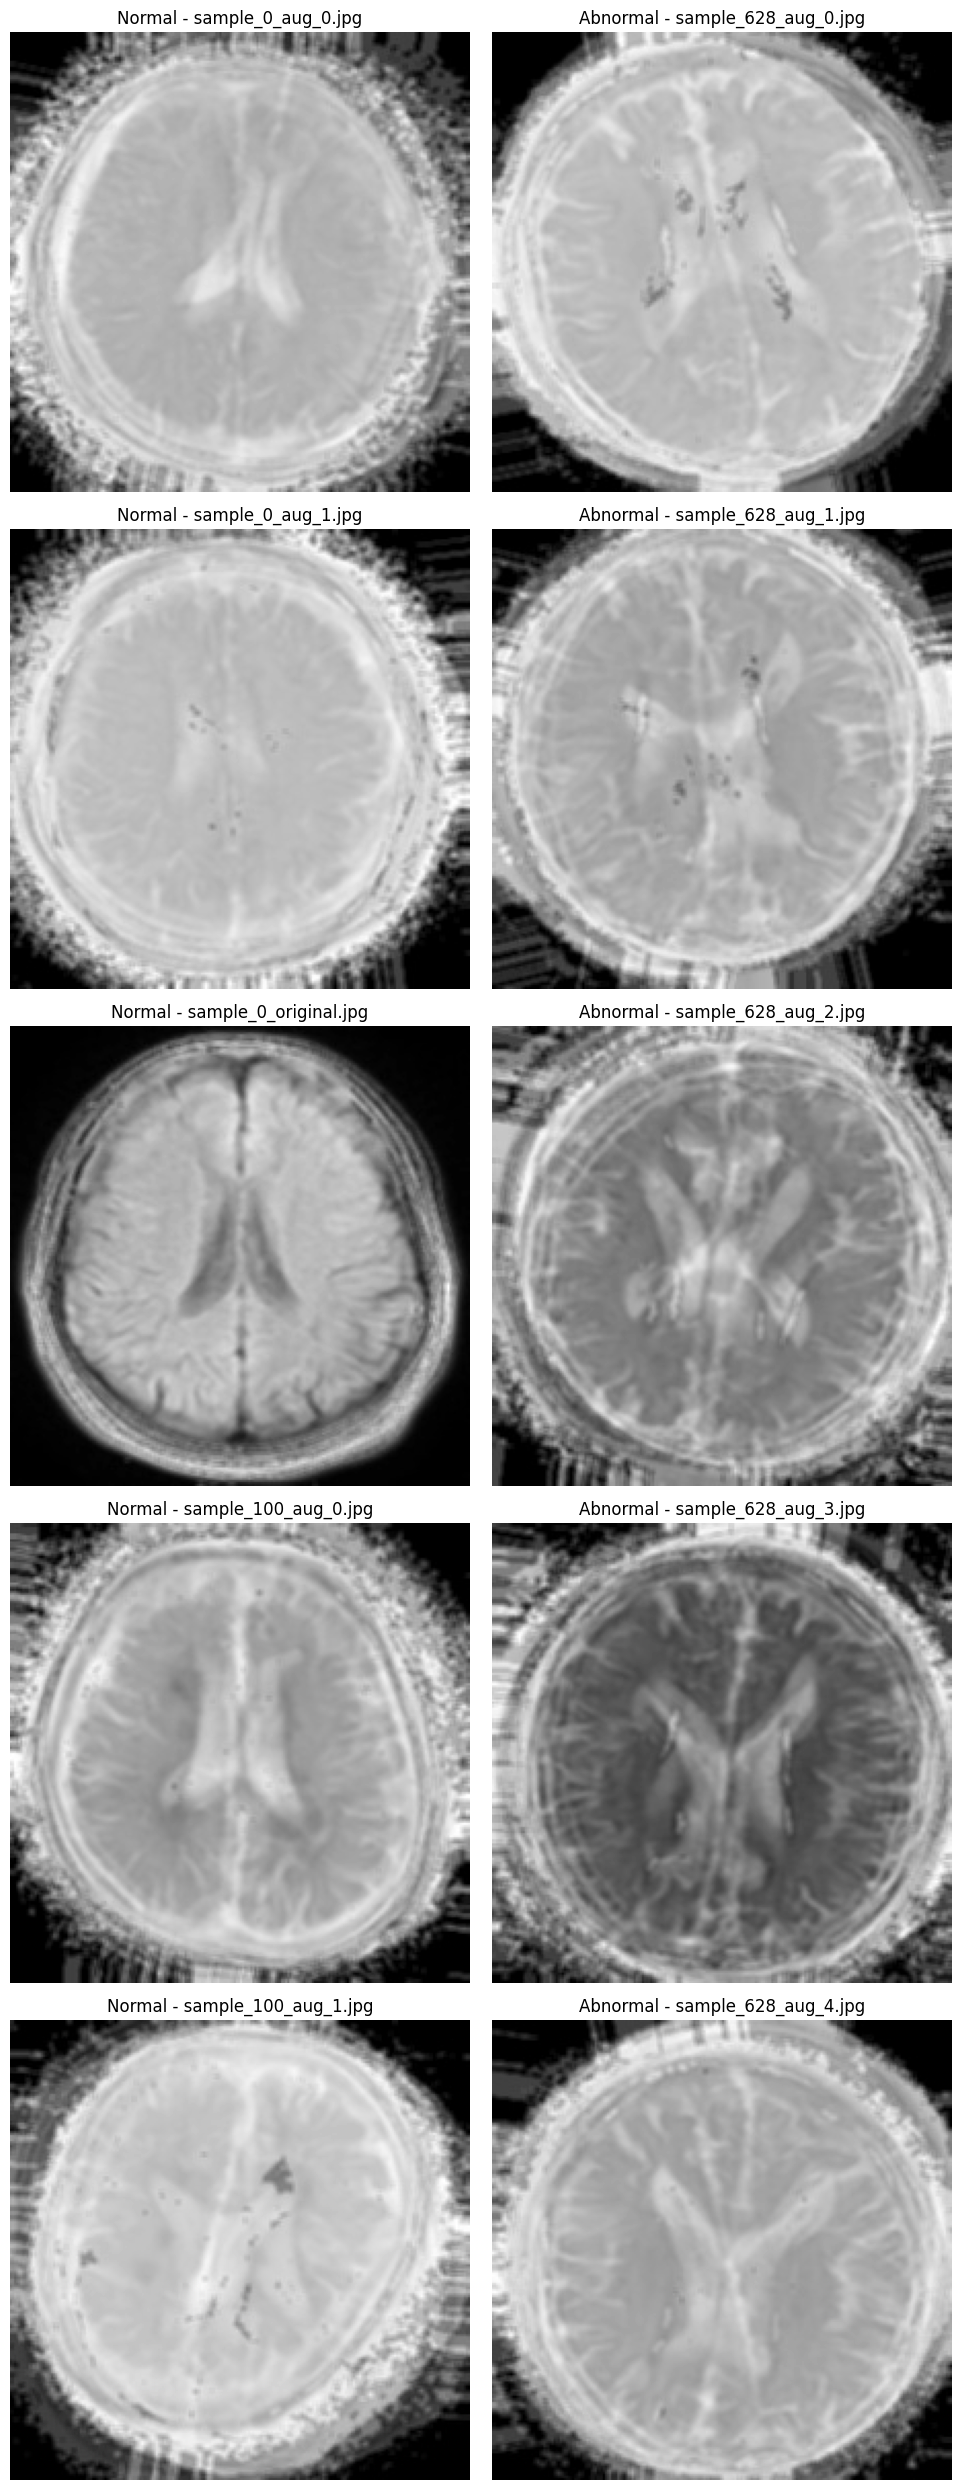

In [35]:
def display_averaged_slices(dst_folder, num_samples=5):
    """
    Displays some of the averaged slices saved as .jpg images.
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    categories = ['normal', 'abnormal']
    for i, category in enumerate(categories):
        category_folder = os.path.join(dst_folder, category)
        
        for j, sample_file in enumerate(sorted(os.listdir(category_folder))[:num_samples]):
            sample_path = os.path.join(category_folder, sample_file)
            
            # Use cv2.imread to load the .jpg image
            averaged_slice = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
            
            # Display the image
            ax = axes[j, i] if num_samples > 1 else axes[i]
            ax.imshow(averaged_slice, cmap='gray')
            ax.set_title(f'{category.capitalize()} - {sample_file}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display some of the averaged slices
display_averaged_slices(dst_folder, num_samples=5)


In [36]:
src_folder = '/kaggle/working/train_crop'
dst_folder = '/kaggle/working/TRAIN_AVG_O'

average_slices_and_save(src_folder, dst_folder)

100%|██████████| 91/91 [00:00<00:00, 478.92it/s]

Slices averaged and saved successfully!


In [37]:

src_folder = '/kaggle/working/val_crop'
dst_folder = '/kaggle/working/VAL_AVG'

average_slices_and_save(src_folder, dst_folder)

src_folder = '/kaggle/working/test_crop'
dst_folder = '/kaggle/working/TEST_AVG'

average_slices_and_save(src_folder, dst_folder)

100%|██████████| 20/20 [00:00<00:00, 454.17it/s]


Slices averaged and saved successfully!


100%|██████████| 21/21 [00:00<00:00, 477.14it/s]

Slices averaged and saved successfully!


In [38]:
def load_images_and_labels(folder, img_size=(224, 224)):
    categories = ['normal', 'abnormal']
    X = []
    y = []

    for category in categories:
        label = 0 if category == 'normal' else 1
        category_folder = os.path.join(folder, category)
        
        for img_file in os.listdir(category_folder):
            img_path = os.path.join(category_folder, img_file)
            img = cv2.imread(img_path)
            
            # Resize the image to the input size expected by the model
            #img_resized = cv2.resize(img, img_size)
            
            # Convert grayscale to RGB by duplicating the channel 3 times
            if img.ndim == 2:  # If the image is grayscale
                img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else:
                img_rgb = img  # If already RGB
            
            # Normalize the image by dividing by 255.0 to get values in range [0, 1]
            #img_rgb_normalized = img_rgb / 255.0
            
            X.append(img_rgb)
            y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


X_train_avg, y_train = load_images_and_labels('/kaggle/working/TRAIN_AVG', img_size=(224, 224))


In [39]:
X_val_avg, y_val = load_images_and_labels('/kaggle/working/VAL_AVG', img_size=(224, 224))
X_test_avg, y_test = load_images_and_labels('/kaggle/working/TEST_AVG', img_size=(224, 224))

In [40]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator with your chosen augmentation settings
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    vertical_flip=True
)

# Set paths
TRAIN_DIR = '/kaggle/working/TRAIN_AVG_O/'
AUGMENTED_DIR = 'AUGMENTED_TRAIN_CROP_O/'
os.makedirs(AUGMENTED_DIR, exist_ok=True)

for class_folder in os.listdir(TRAIN_DIR):
    if class_folder == "normal":
        N = 2
    else:
        N = 5
    
    class_path = os.path.join(TRAIN_DIR, class_folder)
    augmented_dir = os.path.join(AUGMENTED_DIR, class_folder)
    os.makedirs(augmented_dir, exist_ok=True) 

    # Loop through each sample file
    for j, sample_file in enumerate(os.listdir(class_path)):
        sample_path = os.path.join(class_path, sample_file)  # Correct full path for the image
        img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        
        if img is None:
            print(f"Error loading image: {sample_path}")
            continue  # Skip this image if it couldn't be loaded

        # Generate and save N augmented samples
        for aug_idx in range(N):  # N different augmentations
            img_slice = img.reshape((1,) + img.shape + (1,))  # Reshape to (1, height, width, 1)
            aug_iter = demo_datagen.flow(img_slice, batch_size=1)
            
            augmented_img = next(aug_iter)[0]  # Get augmented image
            augmented_img = (augmented_img * 255).astype(np.uint8)  # Rescale back to original scale
            
            save_path = os.path.join(augmented_dir, f'sample_{j}_{aug_idx}.jpg')
            cv2.imwrite(save_path, augmented_img)
        
        # Save the original image
        original_save_path = os.path.join(augmented_dir, f'slice_{j}_original.jpg')  # Fixed semicolon
        cv2.imwrite(original_save_path, img)

print("Augmentation complete!")


Augmentation complete!


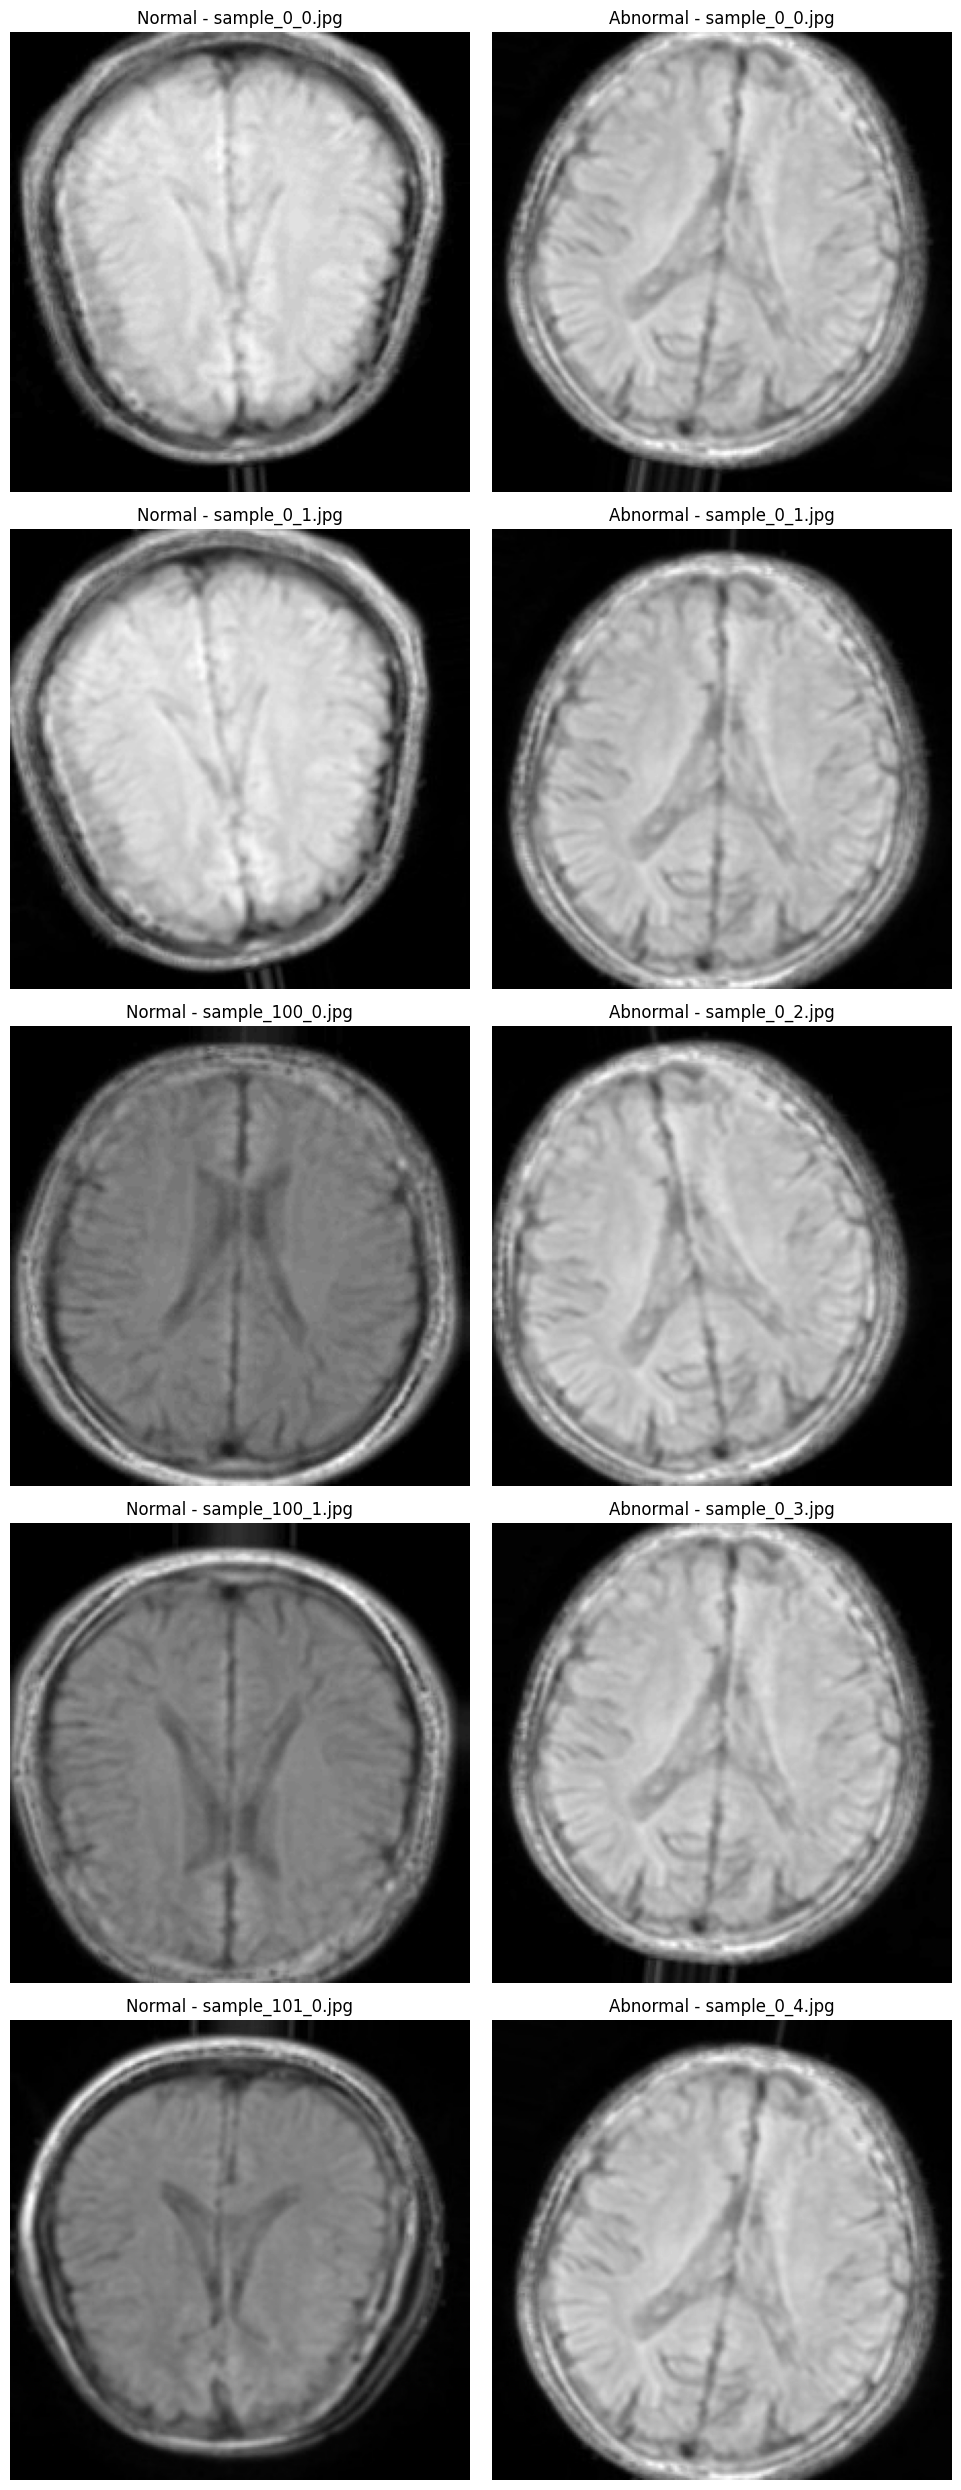

In [41]:
display_averaged_slices('AUGMENTED_TRAIN_CROP_O', num_samples=5)

In [42]:
X_train_avg_O, y_train_O = load_images_and_labels('/kaggle/working/AUGMENTED_TRAIN_CROP_O', img_size=(224, 224))


In [43]:
X_train_avg_n, y_train_n = load_images_and_labels('/kaggle/working/TRAIN_AVG_O', img_size=(224, 224))


In [44]:
TRAIN_DIR = 'TRAIN_AVG/'
VAL_DIR = 'VAL_AVG/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2430 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [46]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_O),
    y=y_train_O
)
class_weight_dict = dict(enumerate(class_weights))

In [47]:
def plot_confusion_matrix(cm, classes, normalize=False):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    
def evaluator (X_val_avg, y_val, model_address):
    print("model_address: ", model_address)
    model = load_model(model_address)
    predictions_prob = model.predict(X_val_avg,verbose=0)
    #print(predictions_prob[:10])
    predictions = [1 if x > 0.5 else 0 for x in predictions_prob]

    # Calculate metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    auc = roc_auc_score(y_val, predictions)
    auc_pr = average_precision_score(y_val, predictions)
    auc_pr_prob = average_precision_score(y_val, predictions_prob)
    f1 = f1_score(y_val, predictions)

    print('Val Accuracy = %.2f' % accuracy)
    print('Val Precision = %.2f' % precision)
    print('Val Recall = %.2f' % recall)
    print('Val AUC = %.2f' % auc)
    print('Val AUC-PR_PROB = %.2f' % auc_pr_prob)
    print('Val AUC-PR = %.2f' % auc_pr)
    print('Val F1 Score = %.2f' % f1)
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_val, predictions)

    plot_confusion_matrix(confusion_mtx, classes=['normal', 'abnormal'], normalize=False)
 

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/100


I0000 00:00:1727448640.264193     219 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 [==============================] - ETA: 0s - loss: 0.7798 - accuracy: 0.5169 - auc: 0.5390 - auc_1: 0.2437
Epoch 1: val_auc_1 improved from -inf to 0.42170, saving model to best_model_AB_vs.keras
19/19 [==============================] - 25s 657ms/step - loss: 0.7798 - accuracy: 0.5169 - auc: 0.5390 - auc_1: 0.2437 - val_loss: 0.6146 - val_accuracy: 0.6824 - val_auc: 0.6469 - val_auc_1: 0.4217
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5918 - auc: 0.6516 - auc_1: 0.3453
Epoch 2: val_auc_1 did not improve from 0.42170
19/19 [==============================] - 4s 201ms/step - loss: 0.6893 - accuracy: 0.5918 - auc: 0.6516 - auc_1: 0.3453 - val_loss: 0.4756 - val_accuracy: 0.8041 - val_auc: 0.6885 - val_auc_1: 0.3873
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.6288 - auc: 0.7079 - auc_1: 0.4140
Epoch 3: val_auc_1 improved from 0.42170 to 0.43796, saving model to best_model_AB_vs.keras
19/19 [==

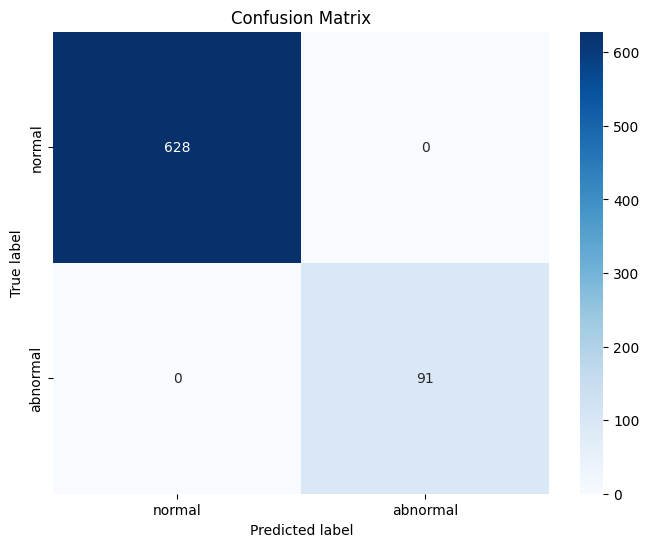

model_address:  best_model_AB_vs.keras
Val Accuracy = 0.89
Val Precision = 0.64
Val Recall = 0.35
Val AUC = 0.66
Val AUC-PR = 0.31
Val AUC-PR_PROB = 0.51
Val F1 Score = 0.45


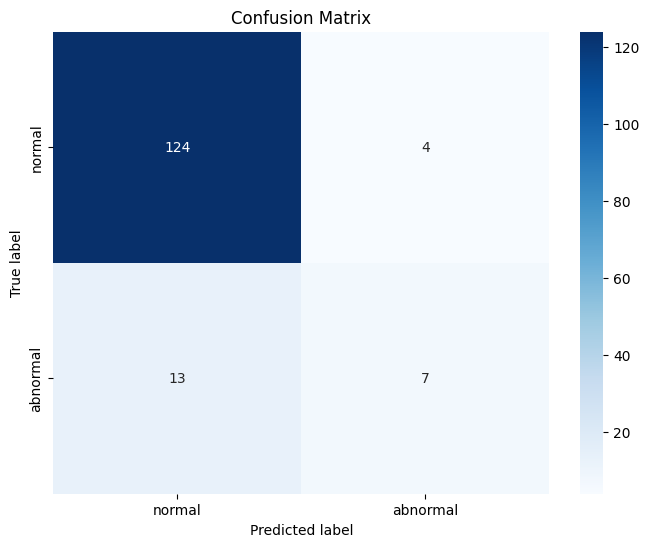

model_address:  best_model_AB_vs.keras
Val Accuracy = 0.90
Val Precision = 0.70
Val Recall = 0.33
Val AUC = 0.66
Val AUC-PR = 0.31
Val AUC-PR_PROB = 0.60
Val F1 Score = 0.45


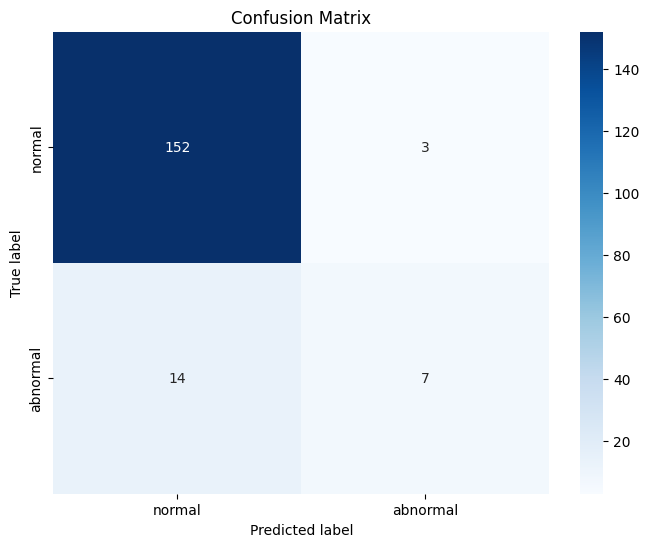

In [48]:
#from tensorflow.keras import regularizers

# Load the base model with pre-trained weights
base_Neural_Net = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freeze the layers of the base model
for layer in base_Neural_Net.layers:
    layer.trainable = False
    #print("here")


# Build the model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(16, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(1, 
                activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization



learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)   

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

# Print the model summary
#model.summary()
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_avg, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_avg, y_val))
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

EPOCHS = 100
es = EarlyStopping(
    monitor='val_auc_1', 
    mode='max',
    patience=15
)
checkpoint = ModelCheckpoint(
    'best_model_AB_vs.keras',        
    monitor='val_auc_1',    
    mode='max',              
    save_best_only=True,     
    verbose=2
)

# Model training
history = model.fit(
    train_dataset,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weight_dict, 
    callbacks=[es, checkpoint],
    verbose=2
)
evaluator (X_train_avg_n, y_train_n, 'best_model_AB_vs.keras')  
evaluator (X_val_avg, y_val,'best_model_AB_vs.keras') 
evaluator (X_test_avg, y_test,'best_model_AB_vs.keras') 

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.9157 - accuracy: 0.4922 - auc_2: 0.5021 - auc_3: 0.2121
Epoch 1: val_auc_3 improved from -inf to 0.31360, saving model to best_model_AB.keras
19/19 [==============================] - 13s 347ms/step - loss: 0.9157 - accuracy: 0.4922 - auc_2: 0.5021 - auc_3: 0.2121 - val_loss: 2.7216 - val_accuracy: 0.1351 - val_auc_2: 0.6701 - val_auc_3: 0.3136
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.8531 - accuracy: 0.5391 - auc_2: 0.5743 - auc_3: 0.2606
Epoch 2: val_auc_3 improved from 0.31360 to 0.40339, saving model to best_model_AB.keras
19/19 [==============================] - 5s 282ms/step - loss: 0.8531 - accuracy: 0.5391 - auc_2: 0.5743 - auc_3: 0.2606 - val_loss: 1.0947 - val_accuracy: 0.3919 - val_auc_2: 0.6814 - val_auc_3: 0.4034
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.7869 - accuracy: 0.5630 - auc_2: 0.6263 - auc_3: 0.3050
Epoch 3: val_auc_3 did not improve fr

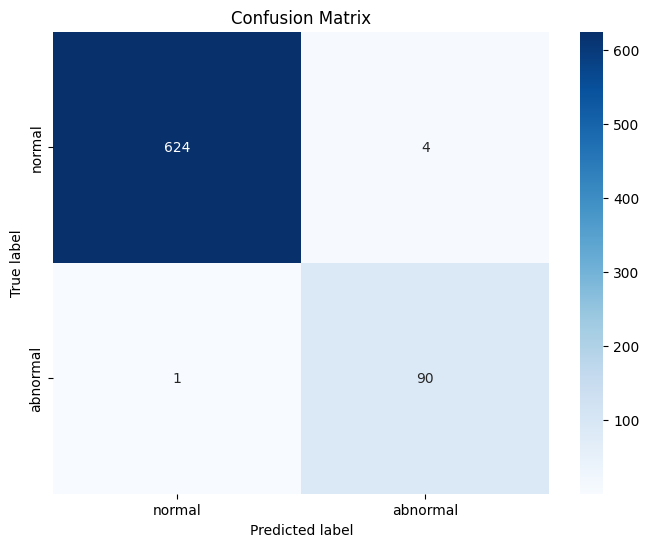

model_address:  best_model_AB.keras
Val Accuracy = 0.88
Val Precision = 0.55
Val Recall = 0.55
Val AUC = 0.74
Val AUC-PR = 0.36
Val AUC-PR_PROB = 0.54
Val F1 Score = 0.55


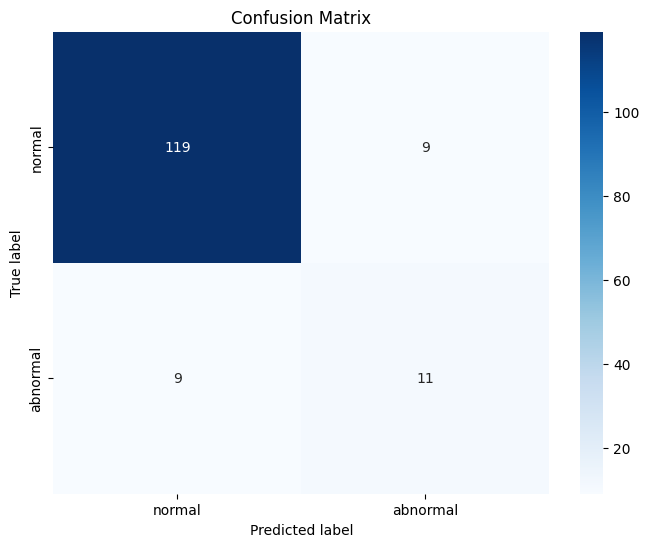

model_address:  best_model_AB.keras
Val Accuracy = 0.89
Val Precision = 0.55
Val Recall = 0.52
Val AUC = 0.73
Val AUC-PR = 0.34
Val AUC-PR_PROB = 0.52
Val F1 Score = 0.54


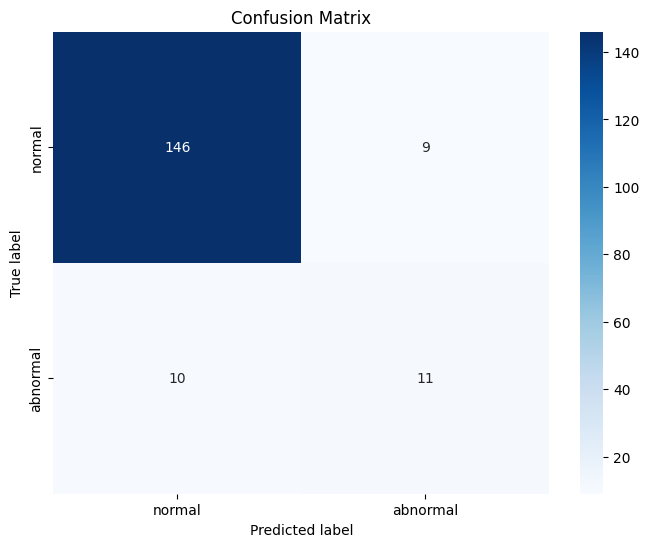

In [60]:
#good, increaced its patience(accuracy wasn't worrying)
base_Neural_Net = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_Neural_Net.layers:
    layer.trainable = False
    
# Build the model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())

# First Dense layer
model.add(Dense(64, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

# Add another learnable Dense layer
model.add(Dense(32, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization for new layer
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))  # Reduced dropout for this layer

# Output layer
model.add(Dense(1, 
                activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization

# Set optimizer with a custom learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)   

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

# model.summary()
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_avg, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_avg, y_val))
validation_dataset = validation_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

EPOCHS = 100
es = EarlyStopping(
    monitor='val_auc_3', 
    mode='max',
    patience=15
)

checkpoint = ModelCheckpoint(
    'best_model_AB.keras',        
    monitor='val_auc_3',    
    mode='max',              
    save_best_only=True,     
    verbose=2
)

# Model training
history = model.fit(
    train_dataset,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weight_dict, 
    callbacks=[es, checkpoint],
    verbose=2
)
evaluator (X_train_avg_n, y_train_n, 'best_model_AB.keras')  
evaluator (X_val_avg, y_val,'best_model_AB.keras') 
evaluator (X_test_avg, y_test, 'best_model_AB.keras') 

In [70]:
model.save('best_model_AB.keras', save_format='tf')

from IPython.display import FileLink
FileLink(r'best_model_AB.keras')

/kaggle/working/best_model_AB.keras

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.9608 - accuracy: 0.5255 - auc_4: 0.5018 - auc_5: 0.2315
Epoch 1: val_auc_5 improved from -inf to 0.34088, saving model to best_model_O.keras
19/19 [==============================] - 12s 346ms/step - loss: 0.9608 - accuracy: 0.5255 - auc_4: 0.5018 - auc_5: 0.2315 - val_loss: 0.5378 - val_accuracy: 0.8581 - val_auc_4: 0.6662 - val_auc_5: 0.3409
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.8472 - accuracy: 0.5782 - auc_4: 0.5931 - auc_5: 0.2935
Epoch 2: val_auc_5 improved from 0.34088 to 0.41473, saving model to best_model_O.keras
19/19 [==============================] - 5s 280ms/step - loss: 0.8472 - accuracy: 0.5782 - auc_4: 0.5931 - auc_5: 0.2935 - val_loss: 0.4865 - val_accuracy: 0.8581 - val_auc_4: 0.7238 - val_auc_5: 0.4147
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.7683 - accuracy: 0.5971 - auc_4: 0.6526 - auc_5: 0.3746
Epoch 3: val_auc_5 improved from 0.4147

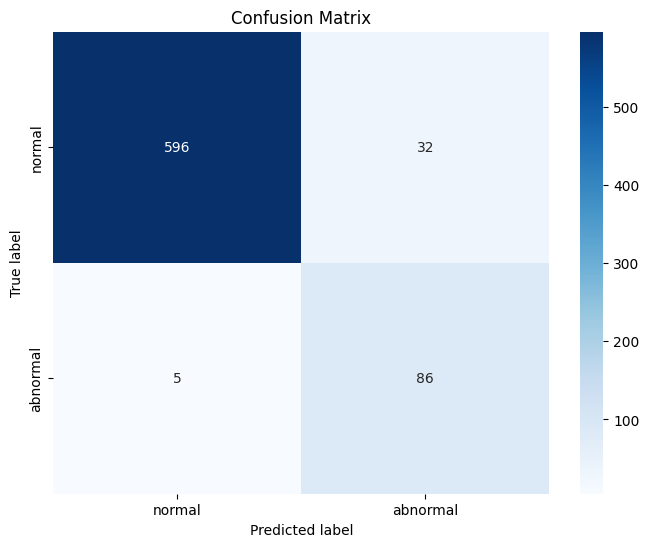

model_address:  best_model_O.keras
Val Accuracy = 0.83
Val Precision = 0.41
Val Recall = 0.60
Val AUC = 0.73
Val AUC-PR = 0.30
Val AUC-PR_PROB = 0.53
Val F1 Score = 0.49


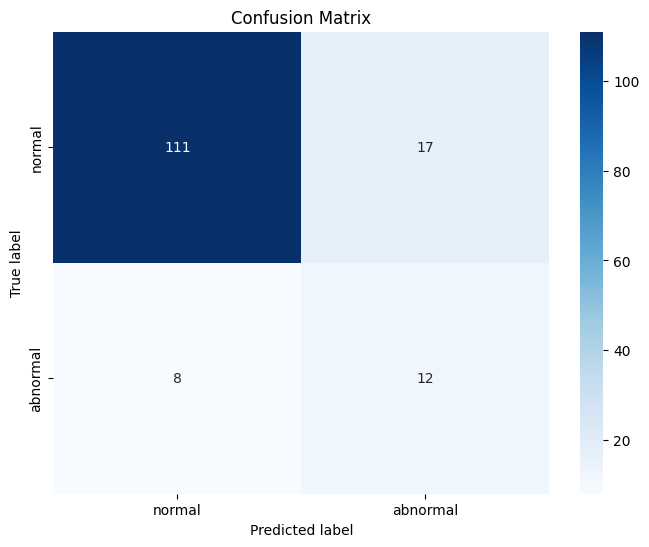

model_address:  best_model_O.keras
Val Accuracy = 0.84
Val Precision = 0.38
Val Recall = 0.52
Val AUC = 0.70
Val AUC-PR = 0.26
Val AUC-PR_PROB = 0.43
Val F1 Score = 0.44


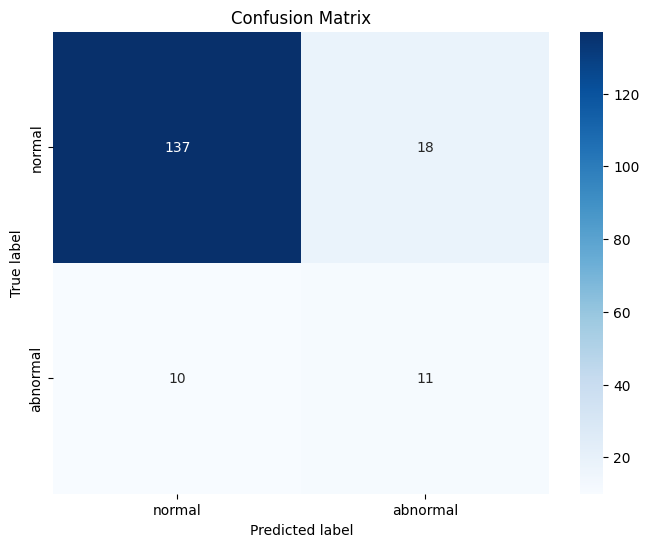

In [61]:
#can't decide quite yet
base_Neural_Net = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_Neural_Net.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())

# First Dense layer
model.add(Dense(64, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

# Add another learnable Dense layer
model.add(Dense(32, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization for new layer
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))  # Reduced dropout for this layer

# Output layer
model.add(Dense(1, 
                activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization



# Set optimizer with a custom learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)   

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

# model.summary()
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_avg_O, y_train_O))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_avg, y_val))
validation_dataset = validation_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

EPOCHS = 100
es = EarlyStopping(
    monitor='val_auc_5', 
    mode='max',
    patience=10
)

checkpoint = ModelCheckpoint(
    'best_model_O.keras',        
    monitor='val_auc_5',    
    mode='max',              
    save_best_only=True,     
    verbose=2
)

# Model training
history = model.fit(
    train_dataset,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weight_dict, 
    callbacks=[es, checkpoint],
    verbose=2
)
evaluator (X_train_avg_n, y_train_n, 'best_model_O.keras')  
evaluator (X_val_avg, y_val,'best_model_O.keras') 
evaluator (X_test_avg, y_test, 'best_model_O.keras') 

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.6356 - auc_6: 0.5041 - auc_7: 0.1470
Epoch 1: val_auc_7 improved from -inf to 0.26170, saving model to /kaggle/working/best_model_n.keras
6/6 [==============================] - 12s 1s/step - loss: 0.7137 - accuracy: 0.6356 - auc_6: 0.5041 - auc_7: 0.1470 - val_loss: 1.0079 - val_accuracy: 0.8581 - val_auc_6: 0.6391 - val_auc_7: 0.2617
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.7135 - auc_6: 0.6134 - auc_7: 0.2543
Epoch 2: val_auc_7 improved from 0.26170 to 0.35376, saving model to /kaggle/working/best_model_n.keras
6/6 [==============================] - 3s 523ms/step - loss: 0.6212 - accuracy: 0.7135 - auc_6: 0.6134 - auc_7: 0.2543 - val_loss: 0.6279 - val_accuracy: 0.8581 - val_auc_6: 0.7121 - val_auc_7: 0.3538
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.7371 - auc_6: 0.6223 - auc_7: 0.2781
Epoch 3: val_auc_7 i

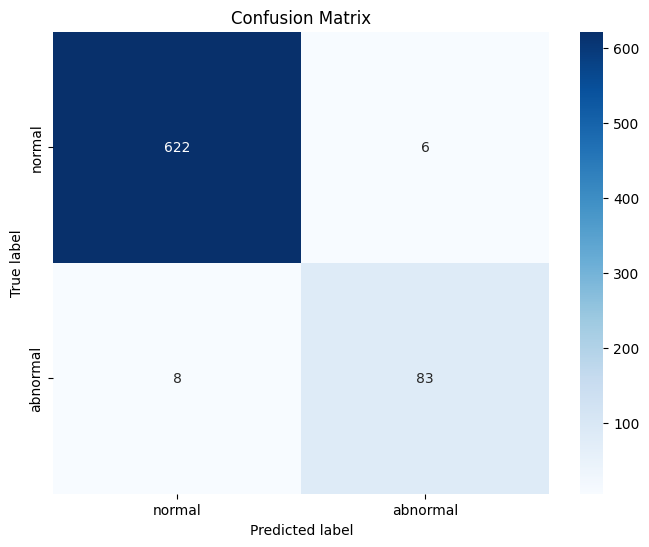

model_address:  best_model_n.keras
Val Accuracy = 0.89
Val Precision = 0.59
Val Recall = 0.50
Val AUC = 0.72
Val AUC-PR = 0.36
Val AUC-PR_PROB = 0.51
Val F1 Score = 0.54


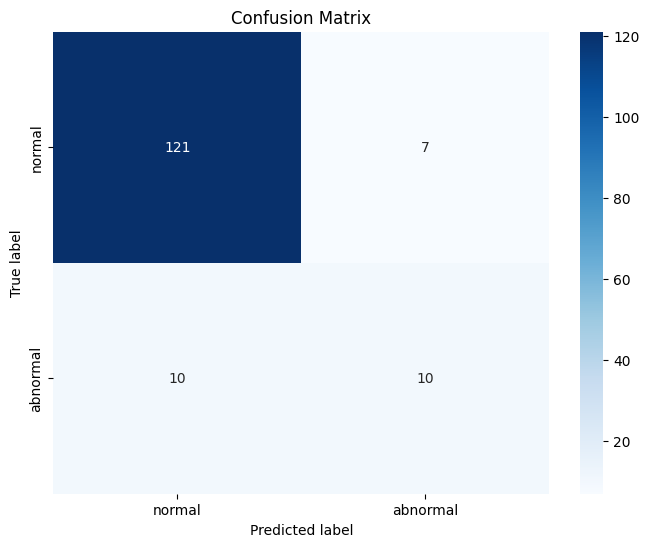

model_address:  best_model_n.keras
Val Accuracy = 0.90
Val Precision = 0.62
Val Recall = 0.38
Val AUC = 0.67
Val AUC-PR = 0.31
Val AUC-PR_PROB = 0.51
Val F1 Score = 0.47


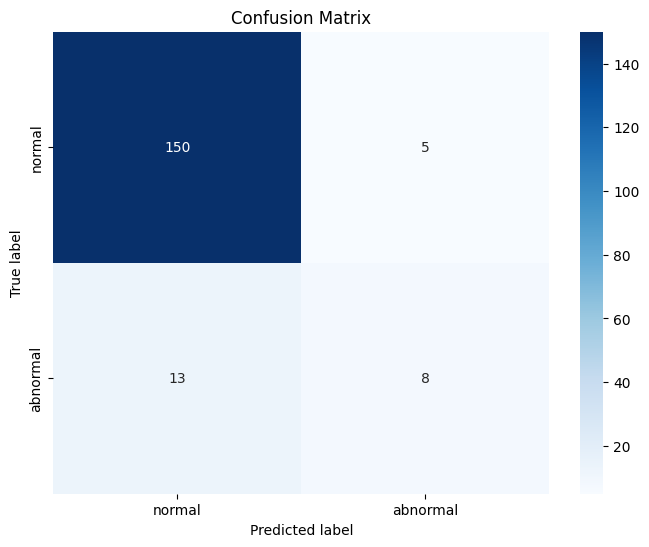

In [63]:
### not our best
base_Neural_Net = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_Neural_Net.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())

# First Dense layer
model.add(Dense(64, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

# Add another learnable Dense layer
model.add(Dense(32, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization for new layer
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))  # Reduced dropout for this layer

# Output layer
model.add(Dense(1, 
                activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization


# Set optimizer with a custom learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)   

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

# model.summary()
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_avg_n, y_train_n))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_avg, y_val))
validation_dataset = validation_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

EPOCHS = 100
es = EarlyStopping(
    monitor='val_auc_7', 
    mode='max',
    patience=10
)

checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_n.keras',        
    monitor='val_auc_7',    
    mode='max',              
    save_best_only=True,     
    verbose=2
)

# Model training
history = model.fit(
    train_dataset,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weight_dict, 
    callbacks=[es, checkpoint],
    verbose=2
)

evaluator (X_train_avg_n, y_train_n, 'best_model_n.keras')  
evaluator (X_val_avg, y_val,'best_model_n.keras') 
evaluator (X_test_avg, y_test, 'best_model_n.keras') 

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.8132 - accuracy: 0.6495 - auc_8: 0.4792 - auc_9: 0.1228
Epoch 1: val_auc_9 improved from -inf to 0.13514, saving model to best_model_n_s.keras
6/6 [==============================] - 9s 754ms/step - loss: 0.8132 - accuracy: 0.6495 - auc_8: 0.4792 - auc_9: 0.1228 - val_loss: 2.5767 - val_accuracy: 0.8649 - val_auc_8: 0.5000 - val_auc_9: 0.1351
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.7204 - auc_8: 0.6049 - auc_9: 0.2089
Epoch 2: val_auc_9 improved from 0.13514 to 0.31159, saving model to best_model_n_s.keras
6/6 [==============================] - 3s 532ms/step - loss: 0.6973 - accuracy: 0.7204 - auc_8: 0.6049 - auc_9: 0.2089 - val_loss: 1.4294 - val_accuracy: 0.8716 - val_auc_8: 0.5805 - val_auc_9: 0.3116
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.6347 - accuracy: 0.7079 - auc_8: 0.6603 - auc_9: 0.2827
Epoch 3: val_auc_9 improved from 0.31159 to 0.

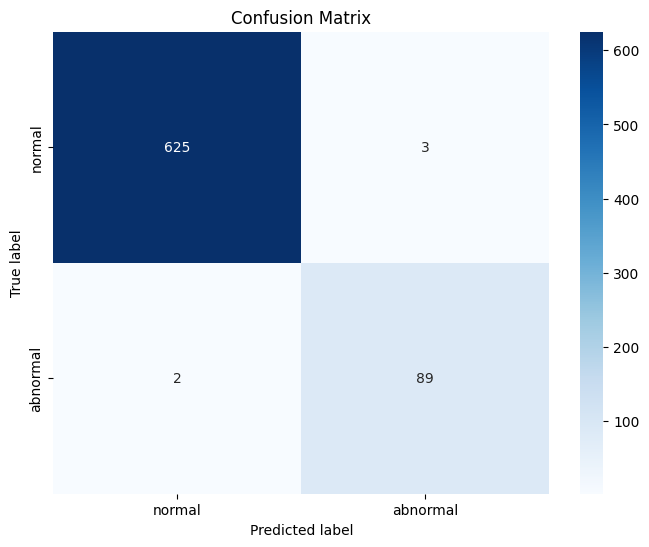

model_address:  best_model_n_s.keras
Val Accuracy = 0.90
Val Precision = 0.73
Val Recall = 0.40
Val AUC = 0.69
Val AUC-PR = 0.37
Val AUC-PR_PROB = 0.51
Val F1 Score = 0.52


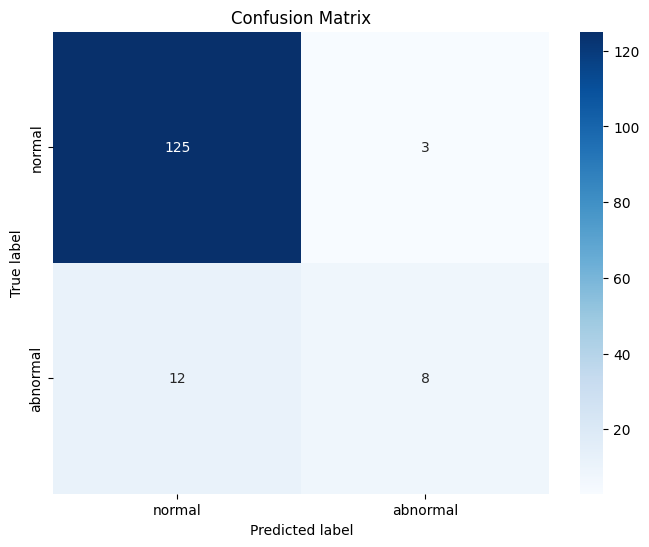

model_address:  best_model_n_s.keras
Val Accuracy = 0.89
Val Precision = 0.57
Val Recall = 0.38
Val AUC = 0.67
Val AUC-PR = 0.29
Val AUC-PR_PROB = 0.47
Val F1 Score = 0.46


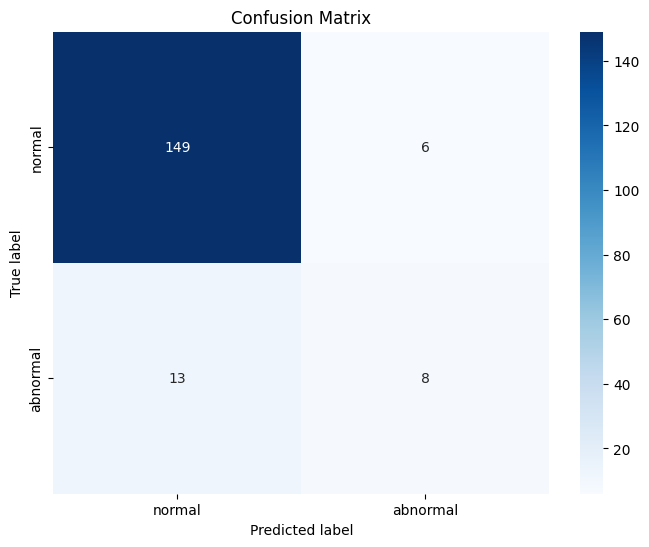

In [64]:
### wild card
base_Neural_Net = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_Neural_Net.layers:
    layer.trainable = False
    
# Build the model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())

# First Dense layer
model.add(Dense(64, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0005)))  # L2 regularization
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

# Add another learnable Dense layer
model.add(Dense(32, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization for new layer
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))  # Reduced dropout for this layer

# Output layer
model.add(Dense(1, 
                activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.0001)))  # L2 regularization


# Set optimizer with a custom learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)   

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

# model.summary()
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_avg_n, y_train_n))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_avg, y_val))
validation_dataset = validation_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

EPOCHS = 100
es = EarlyStopping(
    monitor='val_auc_9', 
    mode='max',
    patience=20
)

checkpoint = ModelCheckpoint(
    'best_model_n_s.keras',        
    monitor='val_auc_9',    
    mode='max',              
    save_best_only=True,     
    verbose=2
)

# Model training
history = model.fit(
    train_dataset,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weight_dict, 
    callbacks=[es, checkpoint],
    verbose=2
)
evaluator (X_train_avg_n, y_train_n, 'best_model_n_s.keras')  
evaluator (X_val_avg, y_val,'best_model_n_s.keras') 
evaluator (X_test_avg, y_test, 'best_model_n_s.keras') 

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.8460 - accuracy: 0.5881 - auc_10: 0.5596 - auc_11: 0.2518
Epoch 1: val_auc_11 improved from -inf to 0.39951, saving model to /kaggle/working/best_model_O_s.keras
19/19 [==============================] - 11s 341ms/step - loss: 0.8460 - accuracy: 0.5881 - auc_10: 0.5596 - auc_11: 0.2518 - val_loss: 1.2230 - val_accuracy: 0.4932 - val_auc_10: 0.7373 - val_auc_11: 0.3995
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.6790 - auc_10: 0.7239 - auc_11: 0.4044
Epoch 2: val_auc_11 improved from 0.39951 to 0.47075, saving model to /kaggle/working/best_model_O_s.keras
19/19 [==============================] - 5s 273ms/step - loss: 0.6640 - accuracy: 0.6790 - auc_10: 0.7239 - auc_11: 0.4044 - val_loss: 0.5343 - val_accuracy: 0.8108 - val_auc_10: 0.7686 - val_auc_11: 0.4708
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.5840 - accuracy: 0.7169 - auc_10: 0.7879 - au

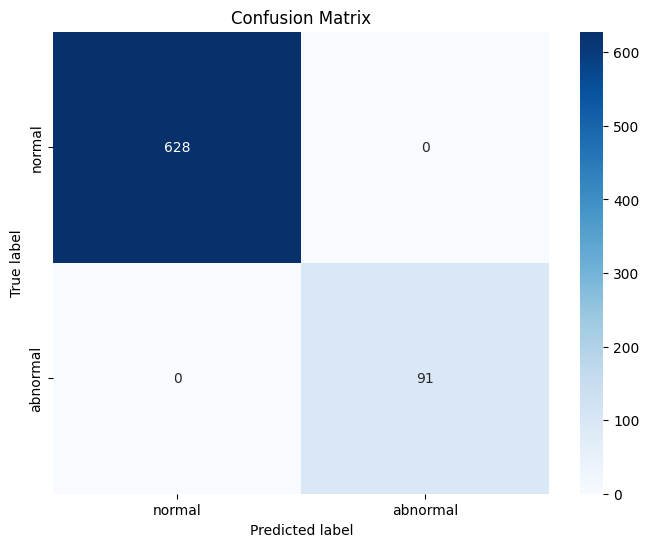

model_address:  best_model_O_s.keras
Val Accuracy = 0.87
Val Precision = 0.54
Val Recall = 0.35
Val AUC = 0.65
Val AUC-PR = 0.28
Val AUC-PR_PROB = 0.52
Val F1 Score = 0.42


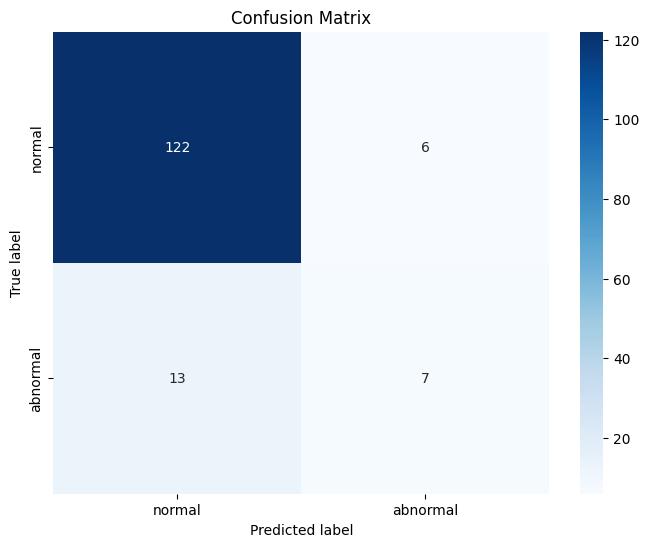

model_address:  best_model_O_s.keras
Val Accuracy = 0.90
Val Precision = 0.59
Val Recall = 0.48
Val AUC = 0.72
Val AUC-PR = 0.34
Val AUC-PR_PROB = 0.59
Val F1 Score = 0.53


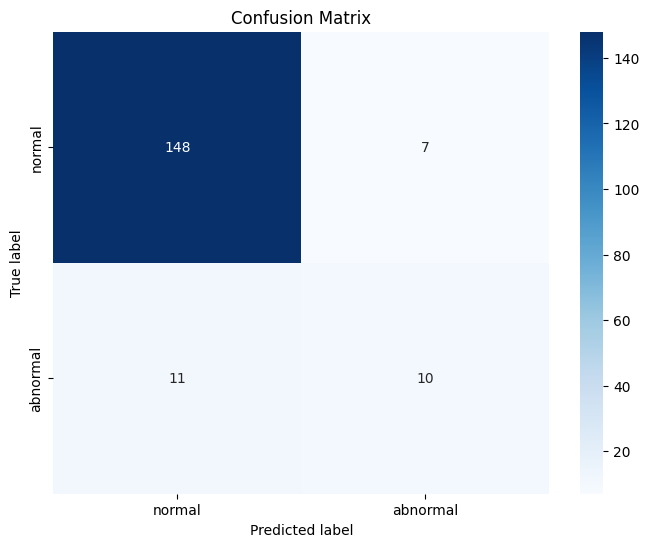

In [65]:
###1
base_Neural_Net = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_Neural_Net.layers:
    layer.trainable = False
    
# Build the model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(1, 
                activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)   

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

# Print the model summary
#model.summary()
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_avg_O, y_train_O))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_avg, y_val))
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

EPOCHS = 100
es = EarlyStopping(
    monitor='val_auc_11', 
    mode='max',
    patience=10
)
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_O_s.keras',        
    monitor='val_auc_11',    
    mode='max',              
    save_best_only=True,     
    verbose=2
)

# Model training
history = model.fit(
    train_dataset,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weight_dict, 
    callbacks=[es, checkpoint],
    verbose=2
)
evaluator (X_train_avg_n, y_train_n, 'best_model_O_s.keras')  
evaluator (X_val_avg, y_val,'best_model_O_s.keras') 
evaluator (X_test_avg, y_test, 'best_model_O_s.keras') 

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.8479 - accuracy: 0.4564 - auc_12: 0.5638 - auc_13: 0.2634
Epoch 1: val_auc_13 improved from -inf to 0.23166, saving model to best_model_AB_vs_O.keras
19/19 [==============================] - 12s 390ms/step - loss: 0.8479 - accuracy: 0.4564 - auc_12: 0.5638 - auc_13: 0.2634 - val_loss: 3.4644 - val_accuracy: 0.1486 - val_auc_12: 0.6619 - val_auc_13: 0.2317
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7254 - accuracy: 0.5321 - auc_12: 0.6811 - auc_13: 0.3559
Epoch 2: val_auc_13 improved from 0.23166 to 0.51103, saving model to best_model_AB_vs_O.keras
19/19 [==============================] - 5s 272ms/step - loss: 0.7254 - accuracy: 0.5321 - auc_12: 0.6811 - auc_13: 0.3559 - val_loss: 1.2556 - val_accuracy: 0.3649 - val_auc_12: 0.7492 - val_auc_13: 0.5110
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.5667 - auc_12: 0.7393 - auc_13: 0.4309
Epoch 3: va

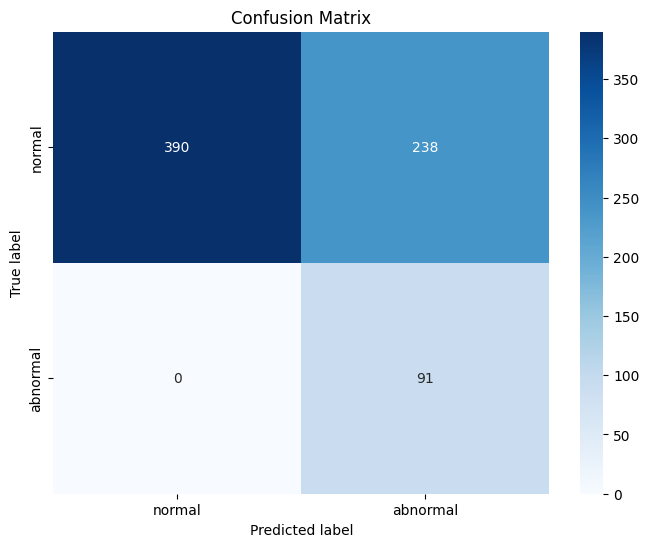

model_address:  best_model_AB_vs_O.keras
Val Accuracy = 0.61
Val Precision = 0.22
Val Recall = 0.75
Val AUC = 0.67
Val AUC-PR = 0.20
Val AUC-PR_PROB = 0.54
Val F1 Score = 0.34


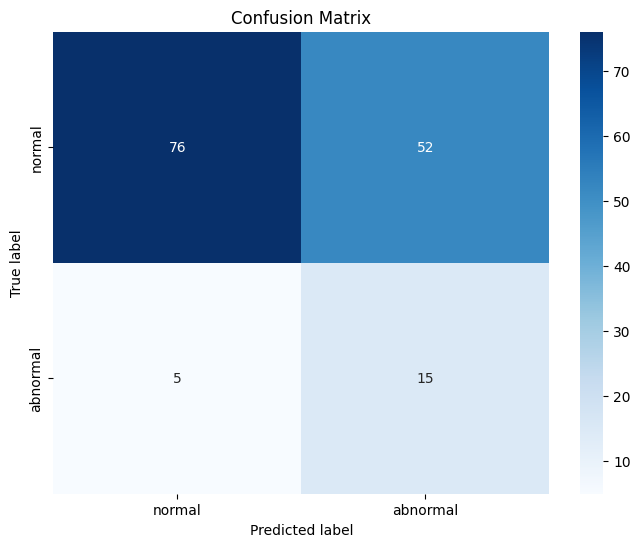

model_address:  best_model_AB_vs_O.keras
Val Accuracy = 0.60
Val Precision = 0.20
Val Recall = 0.81
Val AUC = 0.69
Val AUC-PR = 0.19
Val AUC-PR_PROB = 0.47
Val F1 Score = 0.32


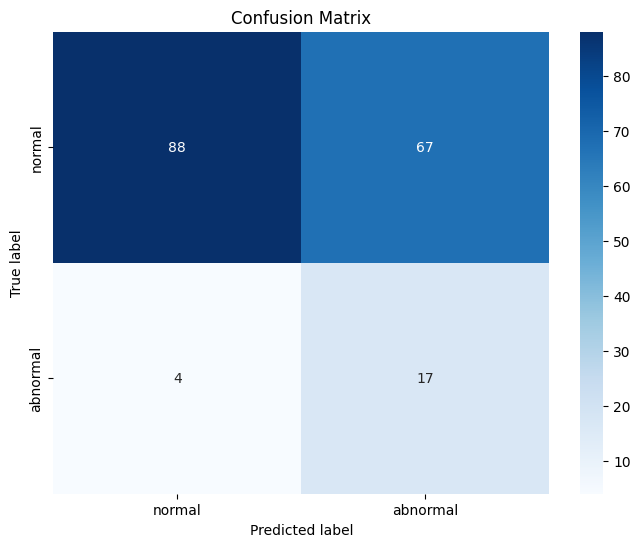

In [66]:
#from tensorflow.keras import regularizers

# Load the base model with pre-trained weights
base_Neural_Net = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_Neural_Net.layers:
    layer.trainable = False
    
# Build the model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(16, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(1, 
                activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)   

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

# Print the model summary
#model.summary()
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_avg_O, y_train_O))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_avg, y_val))
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

EPOCHS = 100
es = EarlyStopping(
    monitor='val_auc_13', 
    mode='max',
    patience=15
)
checkpoint = ModelCheckpoint(
    'best_model_AB_vs_O.keras',        
    monitor='val_auc_13',    
    mode='max',              
    save_best_only=True,     
    verbose=2
)

# Model training
history = model.fit(
    train_dataset,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weight_dict, 
    callbacks=[es, checkpoint],
    verbose=2
)
evaluator (X_train_avg_n, y_train_n, 'best_model_AB_vs_O.keras')  
evaluator (X_val_avg, y_val,'best_model_AB_vs_O.keras') 
evaluator (X_test_avg, y_test, 'best_model_AB_vs_O.keras') 

In [67]:
model.save('best_model_AB_vs_O.keras', save_format='tf')

from IPython.display import FileLink
FileLink(r'best_model_AB_vs_O.keras')

/kaggle/working/best_model_AB_vs_O.keras

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.8550 - accuracy: 0.6358 - auc_14: 0.5774 - auc_15: 0.2684
Epoch 1: val_auc_15 improved from -inf to 0.25902, saving model to best_model_AB_vs_O_2.keras
19/19 [==============================] - 12s 390ms/step - loss: 0.8550 - accuracy: 0.6358 - auc_14: 0.5774 - auc_15: 0.2684 - val_loss: 0.5252 - val_accuracy: 0.8176 - val_auc_14: 0.6238 - val_auc_15: 0.2590
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.6761 - auc_14: 0.6834 - auc_15: 0.3579
Epoch 2: val_auc_15 improved from 0.25902 to 0.42096, saving model to best_model_AB_vs_O_2.keras
19/19 [==============================] - 5s 276ms/step - loss: 0.7151 - accuracy: 0.6761 - auc_14: 0.6834 - auc_15: 0.3579 - val_loss: 0.4332 - val_accuracy: 0.8446 - val_auc_14: 0.7174 - val_auc_15: 0.4210
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.7000 - auc_14: 0.7393 - auc_15: 0.4318
Epoch 3

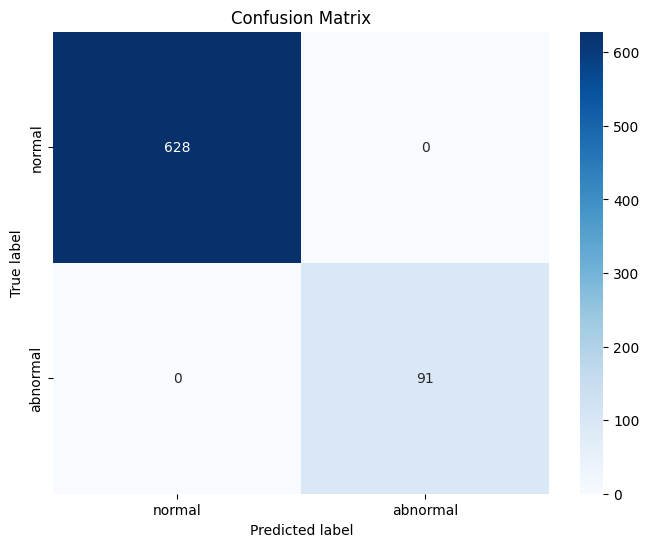

model_address:  best_model_AB_vs_O_2.keras
Val Accuracy = 0.90
Val Precision = 0.69
Val Recall = 0.45
Val AUC = 0.71
Val AUC-PR = 0.39
Val AUC-PR_PROB = 0.56
Val F1 Score = 0.55


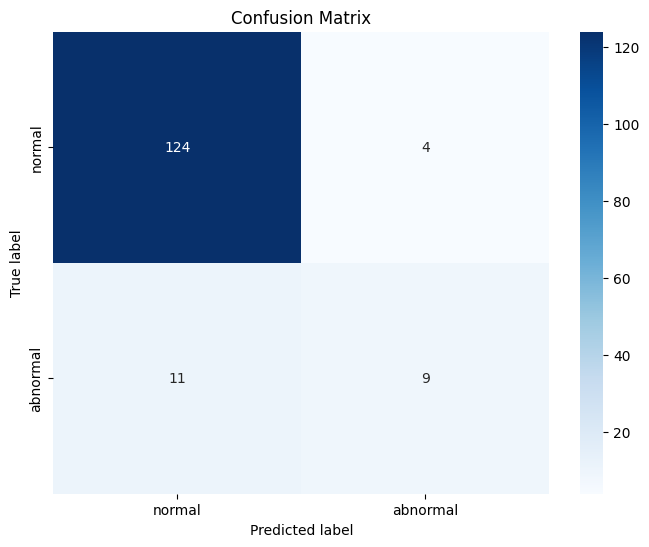

model_address:  best_model_AB_vs_O_2.keras
Val Accuracy = 0.89
Val Precision = 0.58
Val Recall = 0.33
Val AUC = 0.65
Val AUC-PR = 0.27
Val AUC-PR_PROB = 0.56
Val F1 Score = 0.42


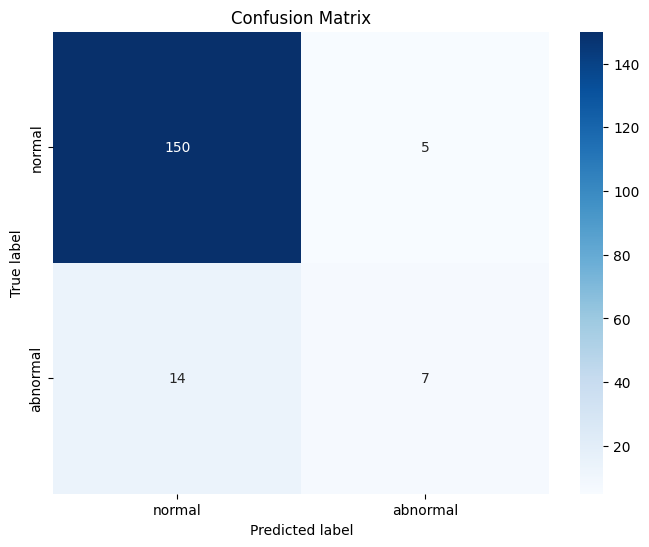

In [68]:
#from tensorflow.keras import regularizers

# Load the base model with pre-trained weights
base_Neural_Net = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_Neural_Net.layers:
    layer.trainable = False
    
# Build the model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(16, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(1, 
                activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)   

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

# Print the model summary
#model.summary()
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_avg_O, y_train_O))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_avg, y_val))
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

EPOCHS = 100
es = EarlyStopping(
    monitor='val_auc_15', 
    mode='max',
    patience=15
)
checkpoint = ModelCheckpoint(
    'best_model_AB_vs_O_2.keras',        
    monitor='val_auc_15',    
    mode='max',              
    save_best_only=True,     
    verbose=2
)

# Model training
history = model.fit(
    train_dataset,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weight_dict, 
    callbacks=[es, checkpoint],
    verbose=2
)
evaluator (X_train_avg_n, y_train_n, 'best_model_AB_vs_O_2.keras')  
evaluator (X_val_avg, y_val,'best_model_AB_vs_O_2.keras') 
evaluator (X_test_avg, y_test, 'best_model_AB_vs_O_2.keras') 

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.8681 - accuracy: 0.5226 - auc_16: 0.5562 - auc_17: 0.2496
Epoch 1: val_auc_17 improved from -inf to 0.20466, saving model to best_model_AB_vs_O_3.keras
19/19 [==============================] - 11s 339ms/step - loss: 0.8681 - accuracy: 0.5226 - auc_16: 0.5562 - auc_17: 0.2496 - val_loss: 3.0767 - val_accuracy: 0.2500 - val_auc_16: 0.6627 - val_auc_17: 0.2047
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.5700 - auc_16: 0.6581 - auc_17: 0.3341
Epoch 2: val_auc_17 improved from 0.20466 to 0.37711, saving model to best_model_AB_vs_O_3.keras
19/19 [==============================] - 5s 274ms/step - loss: 0.7465 - accuracy: 0.5700 - auc_16: 0.6581 - auc_17: 0.3341 - val_loss: 1.0139 - val_accuracy: 0.5338 - val_auc_16: 0.7525 - val_auc_17: 0.3771
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.6008 - auc_16: 0.7340 - auc_17: 0.4318
Epoch 3

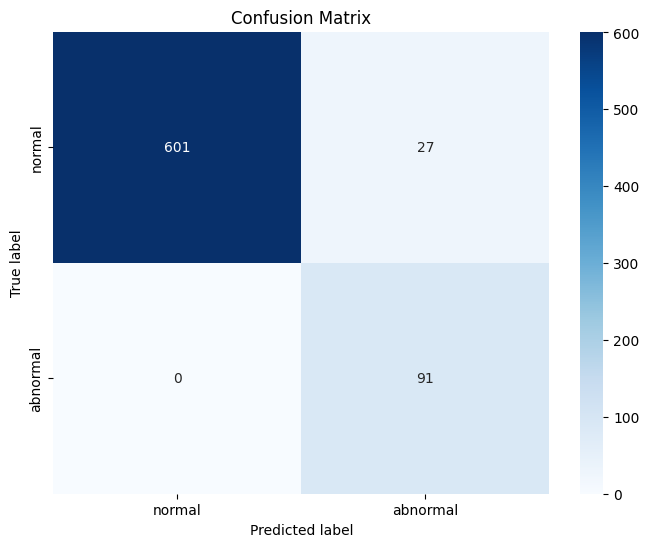

model_address:  best_model_AB_vs_O_3.keras
Val Accuracy = 0.86
Val Precision = 0.48
Val Recall = 0.60
Val AUC = 0.75
Val AUC-PR = 0.34
Val AUC-PR_PROB = 0.51
Val F1 Score = 0.53


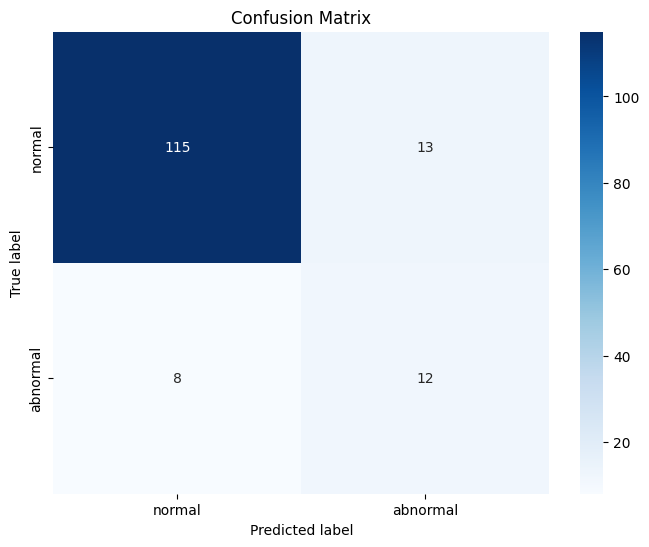

model_address:  best_model_AB_vs_O_3.keras
Val Accuracy = 0.86
Val Precision = 0.44
Val Recall = 0.52
Val AUC = 0.72
Val AUC-PR = 0.29
Val AUC-PR_PROB = 0.45
Val F1 Score = 0.48


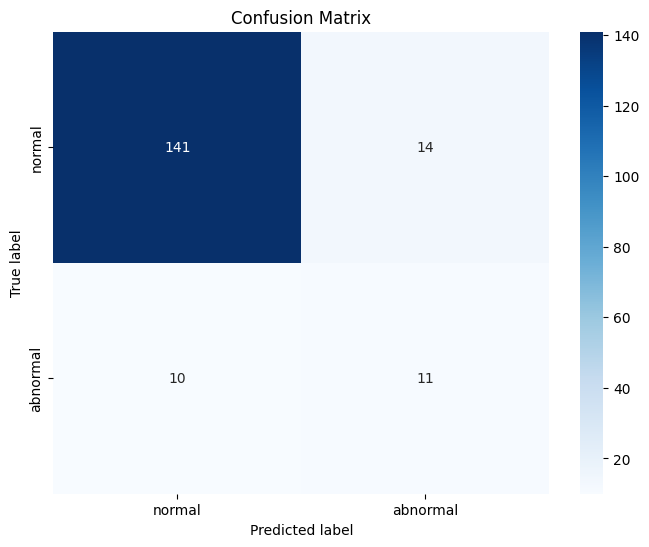

In [69]:

# Load the base model with pre-trained weights
base_Neural_Net = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_Neural_Net.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(16, 
                kernel_initializer='he_uniform', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(1, 
                activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)   

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')]
)

# Print the model summary
#model.summary()
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_avg_O, y_train_O))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_avg, y_val))
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

EPOCHS = 100
es = EarlyStopping(
    monitor='val_auc_17', 
    mode='max',
    patience=15
)
checkpoint = ModelCheckpoint(
    'best_model_AB_vs_O_3.keras',        
    monitor='val_auc_17',    
    mode='max',              
    save_best_only=True,     
    verbose=2
)

# Model training
history = model.fit(
    train_dataset,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weight_dict, 
    callbacks=[es, checkpoint],
    verbose=2
)
evaluator (X_train_avg_n, y_train_n, 'best_model_AB_vs_O_3.keras')  
evaluator (X_val_avg, y_val,'best_model_AB_vs_O_3.keras') 
evaluator (X_test_avg, y_test, 'best_model_AB_vs_O_3.keras') 